In [0]:
# Import the machine learning libraries.
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

In [0]:
def TD0(alpha = 0.1, batch=False, E=101, seed=None):
    if seed:
        np.random.seed(seed) # optional, just useful for consistent debugging
    V = np.zeros(7) + 0.5
    V[0] = 0
    V[6] = 0
    V_s = []
    episodes = []
    for i in range(E):
        V_s.append(deepcopy(V[1:6]))

        episode = []
        updates = np.zeros(7)
        
        # Reprocess previous episodes
        if batch:
            for episode in episodes:
                updates = np.zeros(7)
                for s, reward, s_ in episode:
                    updates[s] += alpha * (reward + V[s_] - V[s])

        s = 3 # Always start at "C"
        while True:
            s_ = s + np.random.choice([-1,1])
            
            if s_ == 6:
                reward = 1
            else:
                reward = 0
            
            episode.append((s, reward, s_))
            
            if batch:
                updates[s] += alpha * (reward + V[s_] - V[s])
            else:
                V[s] = (1-alpha) * V[s] + alpha * (reward + V[s_])

            s = s_

            if s == 6 or s == 0:

                break
        if batch:
            for i in range(6):
                V[i] += updates[i];
                
        episodes.append(episode)
    return V_s

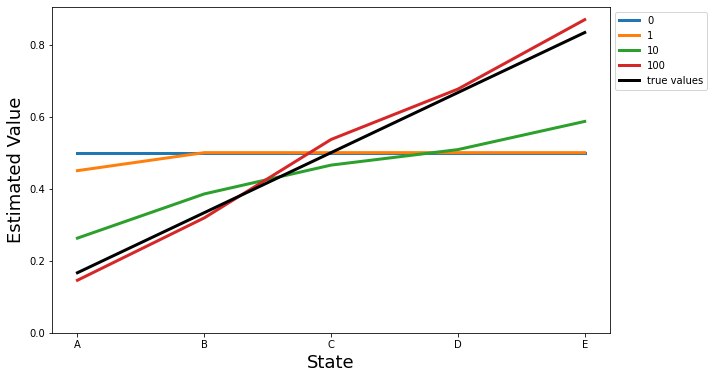

In [30]:
V_s = TD0(seed=9)
fig = plt.figure(figsize=(10, 6))
for i in [0, 1, 10, 100]:
    plt.plot(V_s[i], label=str(i), linewidth=3)
plt.plot([1/6, 2/6, 3/6, 4/6, 5/6], label="true values", linewidth=3, color='black')
plt.xticks([0,1,2,3,4], ["A", "B", "C", "D", "E"])
plt.yticks([0,0.2,0.4,0.6,0.8])
plt.xlabel("State", fontsize=18)
plt.ylabel("Estimated Value", fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

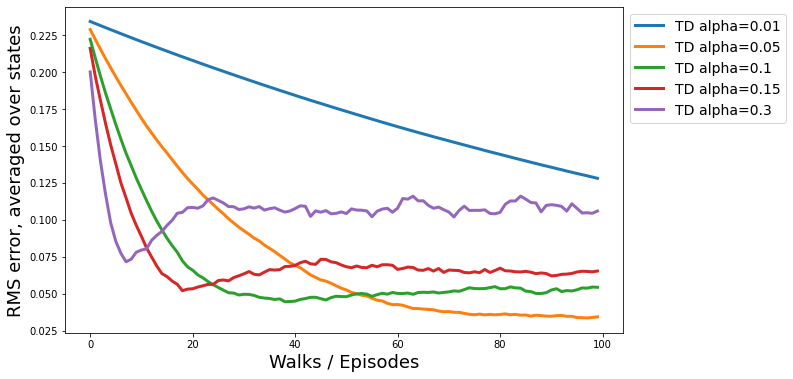

In [31]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

true_V = [1/6, 2/6, 3/6, 4/6, 5/6]
fig = plt.figure(figsize=(10, 6))
for alpha in [0.01, 0.05, 0.1, 0.15, 0.3]:
    errors = np.zeros(100)
    for i in range(100):
        V_s = TD0(alpha)[1:] # skip 0th episode
        for i, V in enumerate(V_s):
            error = rmse(V, true_V)
            errors[i] += error/100
    plt.plot(errors, label="TD alpha={}".format(alpha), linewidth=3)
plt.xlabel("Walks / Episodes", fontsize=18)
plt.ylabel("RMS error, averaged over states", fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=14)
plt.show()

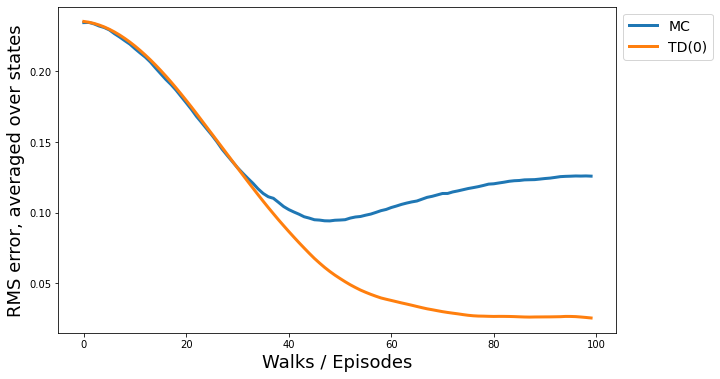

In [32]:
# Batch MC
def MC(alpha = 0.1, batch=False, E=101, seed=None):
    if seed:
        np.random.seed(seed) # optional, just useful for consistent debugging
    V = np.zeros(7) + 0.5
    V[0] = 0
    V[6] = 0
    V_s = []
    episodes = []
    for i in range(E):
        V_s.append(deepcopy(V[1:6]))

        updates = np.zeros(7)
        
        # Reprocess previous episodes
        if batch:
            for episode in episodes:
                for s, reward, s_ in episode:
                    updates[s] += alpha * (reward + V[s_] - V[s])
    
        s = 3 # Always start at "C"
        states = []
        episode = []
        while True:
            states.append(s)
            s_ = s + np.random.choice([-1,1])

            if s_ == 6:
                reward = 1
                episode.append((s, 1, s_))
                break
            elif s_ == 0:
                reward = 0
                episode.append((s, 0, s_))
                break
            s = s_

        for s in states:
            updates[s] += alpha * (reward - V[s])

        if batch:
            for i in range(6):
                V[i] += updates[i];

        episodes.append(episode)
    return V_s
    
errors = np.zeros(100)
trails = 5
fig = plt.figure(figsize=(10, 6))
for i in range(trails):
    V_s = MC(alpha=0.002, batch=True)[1:] # skip 0th episode
    for i, V in enumerate(V_s):
        error = rmse(V, true_V)
        errors[i] += error/trails
plt.plot(errors, label="MC", linewidth=3)

    
# Batch TD(0)
errors = np.zeros(100)
for i in range(trails):
    V_s = TD0(alpha=0.002, batch=True)[1:] # skip 0th episode
    for i, V in enumerate(V_s):
        error = rmse(V, true_V)
        errors[i] += error/trails
plt.plot(errors, label="TD(0)", linewidth=3)
plt.xlabel("Walks / Episodes", fontsize=18)
plt.ylabel("RMS error, averaged over states", fontsize=18)
plt.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=14)
plt.show()